In [2]:
# 2018-10-09
# A. Pendleton
# Intersect the Final gene set with the novel gaps that are in Zoey
#    that were called by Feichen

In [3]:
#this uses iPython magic to make plots appear inline
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import sys
import numpy as np
import matplotlib.patches as patches
import gzip
import fileinput
import glob
from scipy import stats
import re
from matplotlib_venn import venn3, venn3_circles
from collections import OrderedDict


def count_lines(f):
    lineCount = 0
    with open(f, 'r') as f:
        for line in f:
            lineCount += 1
        return lineCount
def runCMD(cmd):
    val = subprocess.Popen(cmd, shell=True).wait()
    if val == 0:
        pass
    else:
        print ('command failed')
        print (cmd)
        sys.exit(1)
# TO REMOVE TOP AND RIGHT AXIS OF PLOTS
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
#Write PBS Script
def write_pbs_file(wkDir,cmdsFile,jobName, mem, jobCount):
    #write PBS file
    if '/scripts/' in wkDir:
        wkDir = wkDir.replace('/scripts/','')
    pbsFile = open(cmdsFile.replace('.cmds','.pbs'),'w')
    print('Writing pbs file: %s'% pbsFile)
    pbsFile.write('#!/bin/bash\n')
    pbsFile.write('#PBS -S /bin/bash\n')
    pbsFile.write('#PBS -V\n')
    pbsFile.write('#PBS -M ampend@med.umich.edu\n')
    pbsFile.write('#PBS -j oe\n')
    pbsFile.write('#PBS -N %s\n' % jobName)
    pbsFile.write('#PBS -o %s\n' % (wkDir + 'logs/'))
    pbsFile.write('#PBS -l pmem=%iG\n' % mem)
    pbsFile.write('#PBS -l nodes=1:ppn=1,qos=flux,walltime=100:00:00\n')
    pbsFile.write('##PBS -A medbsm_flux\n')
    pbsFile.write('##PBS -q flux\n')
    pbsFile.write('#PBS -A jmkidd_fluxod\n')
    pbsFile.write('#PBS -q fluxod\n')
    pbsFile.write('#PBS -t 1-%s\n' % jobCount)
    pbsFile.write('cd %s\n' % (wkDir))
    pbsFile.write('/home/ampend/links/kidd-lab/jmkidd-projects/scripts/perlUtils/run-by-id-log.pl %s %sBLAT_commands.logs $PBS_ARRAYID' % (cmdsFile,cmdsFile.replace('/scripts/','/logs/')))
    pbsFile.close()

# Define Inputs

### CREATE Input 1 = Zoey Exon BED file

##### Extract the exon coordinates from the transdecoder gff3 file which gives us exon positions for ALL genes. 
However, we only want the genes that made it into the final set (N=42,911 genes).


So, you'll need to read in the final gene ID list first, then extract exon positions only for the genes that made it into the final list.

In [10]:
finalDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/'

#Final list of 42,911 genes from Zoey annotations that went through annotations 
FinalGeneList = []
finalGeneIDFile = finalDir + 'FinalGenes_IDs.txt'

for line in open(finalGeneIDFile,'r'):
    line=line.rstrip()
    gene = line
    FinalGeneList.append(gene)

print('Added %i IDs from the final gene list' % len(FinalGeneList))

Added 42911 IDs from the final gene list


In [30]:
gffFile = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/pasa-lite_ZoeyTrinity.pasa_assembled_alignments.genome.gff3'

#Use grep to only get the exons
cmd = 'grep "exon" %s > %s.exonsOnly' % (gffFile,gffFile) 
print(cmd)
runCMD(cmd)

grep "exon" /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/pasa-lite_ZoeyTrinity.pasa_assembled_alignments.genome.gff3 > /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/pasa-lite_ZoeyTrinity.pasa_assembled_alignments.genome.gff3.exonsOnly


In [32]:
gffFile = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/version3_intron500k/transdecoder/results/pasa-lite_ZoeyTrinity.pasa_assembled_alignments.genome.gff3'

exonBedfile = finalDir + 'Zoey_FinalGenes_exons.bed'
exonBedFile = open(exonBedfile,'w')

parentGenes = []
lineCount = 0

for line in open(gffFile + '.exonsOnly','r'):
    line=line.rstrip().split('\t')
    if len(line) < 2:
        continue

    #only interested in exons
    if 'exon' not in line[2]:
        continue

    chrom,start,end = line[0],int(line[3])-1,int(line[4])
    geneID = line[8].split(';')[0].replace('ID=','')
    parentGene = line[8].split(';')[1].replace('Parent=','')
    
    #We only want the final genes
    if parentGene not in FinalGeneList:
        continue
    lineCount+=1 

    parentGenes.append(parentGene) #keep track of the genes that we end up adding to see if we are missing any later
    exonBedFile.write('%s\t%i\t%i\t%s\n' % (chrom,start,end,geneID))
    
    if lineCount % 10000 == 0:
        print(lineCount)
    #if lineCount > 10000: # for testing
        #break
exonBedFile.close()

print('Done with %i exons' % lineCount )
unique_parentGenes = set(parentGenes)
print('From %i genes' % len(set(parentGenes)))

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
Done with 206013 exons


In [39]:
#Check that we didn't miss any exon coordinates
for gene in FinalGeneList:
    if gene not in unique_parentGenes:
        print('ERROR: For some reason we are missing gene: ', gene)
        sys.exit()

### Input 2 = Feichen Gap BED file

In [41]:
gapBedfile = finalDir + 'Intersect_FeichenGaps/' + 'MergedGaps_CfLiftoverToZoey_And_NovelZoeyCoord.bed'


In [43]:
##########################################################################################
##########################################################################################
##########################################################################################

# Intersect the final exons with the novel gaps

In [50]:
intersectOutfile = finalDir + 'Intersect_FeichenGaps/Intersect_ZoeyNovelGaps_with_ZoeyFinalGeneExons.txt'

cmd = 'bedtools intersect -wo -a %s -b %s > %s' % (gapBedfile,exonBedfile,intersectOutfile)
print(cmd)
runCMD(cmd)

bedtools intersect -wo -a /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/Intersect_FeichenGaps/MergedGaps_CfLiftoverToZoey_And_NovelZoeyCoord.bed -b /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/Zoey_FinalGenes_exons.bed > /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/Intersect_FeichenGaps/Intersect_ZoeyNovelGaps_with_ZoeyFinalGeneExons.txt


In [43]:
##########################################################################################
##########################################################################################
##########################################################################################

# Read in the GC content pvalues

In [49]:
GCbed = '/nfs/turbo/jmkiddscr/feichens-projects/Zoey_pacbio/Post_analysis/QuicKmer/ROI_index_in_bianry.bed'

GCDict_pval = {}

for line in open(GCbed,'r'):
    line=line.rstrip().split('\t')
    ID = line[0] + ':' + line[1] + '-' + line[2]
    GCDict_pval[ID] = float(line[5])
    
print('added in GC pvalues for %i windows' % len(GCDict_pval.keys()))

added in GC pvalues for 13839 windows


### Get the pvalues for those windows that intersect with exons

In [82]:
added = []
couldntbeadded = []
pvalues = [] #for plotting the pvalues later
gapLiftPvalues, novelZoeyPvalues = [], [] 

for line in open(intersectOutfile,'r'):
    line=line.rstrip().split('\t')
    ID = line[0] + ':' + line[1] + '-' + line[2]
    
    #only add the gap once for histogram plotting later on
    if ID in added:
        continue
        
    added.append(ID)
    
    #Unfortunately, kmers could only be called in some of the windows, so not every
    #   one will have a pvalue associated with it
    if ID in GCDict_pval.keys():
        pvalue = GCDict_pval[ID]
        pvalues.append(pvalue)
        if '_GapLift' in line[3]:
            gapLiftPvalues.append(pvalue)
        if 'NovelZoey' in line[3]:
            novelZoeyPvalues.append(pvalue)

    else:
        couldntbeadded.append(ID)

print('In total %i gap windows have intersects with at least one exon\n' % len(added))
print('Got the pvalues for %i windows that intersected with exons:' % len(pvalues))
print('%i were the lifted over gaps' % len(gapLiftPvalues))
print('%i were with novel zoey gaps\n' % len(novelZoeyPvalues))
print('No pvalues were available for %i windows that intersected with exons' % len(couldntbeadded))


In total 3876 gap windows have intersects with at least one exon

Got the pvalues for 3422 windows that intersected with exons:
3422 were the lifted over gaps
0 were with novel zoey gaps

No pvalues were available for 454 windows that intersected with exons


### P-value histogram --- All intersects regardless of gap type

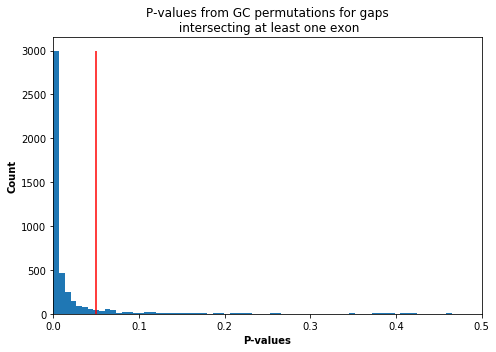

In [73]:
plt.figure(figsize=(7,5))

plt.hist(pvalues,bins=150)
plt.xlim(0,0.5)
plt.vlines(ymin=0,ymax=3000,x=0.05,color='red')
#Add labels and title
plt.title('P-values from GC permutations for gaps\n intersecting at least one exon')
plt.xlabel('P-values',fontweight='bold')
plt.ylabel('Count',fontweight='bold')
plt.tight_layout()
plt.show()

### P-value histogram --- Only Gap Liftover type

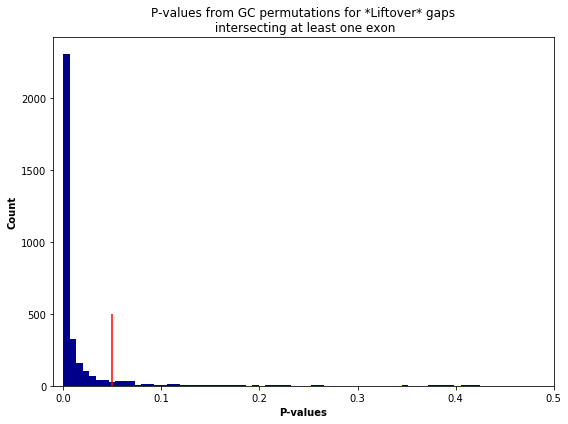

In [90]:
plt.figure(figsize=(8,6))

plt.hist(pvalues,bins=150,color='darkblue')
plt.xlim(-0.01,0.5)
plt.vlines(ymin=0,ymax=500,x=0.05,color='red')
#Add labels and title
plt.title('P-values from GC permutations for *Liftover* gaps\n intersecting at least one exon')
plt.xlabel('P-values',fontweight='bold')
plt.ylabel('Count',fontweight='bold')
plt.tight_layout()
plt.show()